# Classification of emotions

## Importing the libraries

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from google.colab.patches import cv2_imshow
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

## Loading the images

In [17]:
#from google.colab import drive
#drive.mount('/content/drive')

In [18]:
#path = '/content/drive/MyDrive/Computer_Vision_Masterclass_files/Datasets/fer_images.zip'
path = 'Computer_Vision_Masterclass_files/Datasets/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

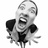

In [19]:
tf.keras.preprocessing.image.load_img('fer2013/train/Angry/1003.jpg')

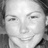

In [20]:
image = tf.keras.preprocessing.image.load_img('fer2013/train/Happy/1.jpg')
image

### Train and test set

In [21]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('fer2013/train',
                                                        target_size = (48, 48),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 28709 images belonging to 7 classes.


In [22]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6])

In [23]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171], dtype=int64))

In [24]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

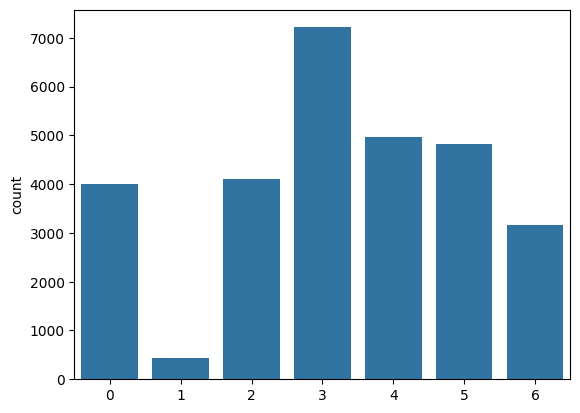

In [25]:
sns.countplot(x = train_dataset.classes);

In [26]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


## Building and training the convolutional neural network

In [27]:
2*2*2*32

256

In [28]:
# Based on: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
# BatchNormalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
num_detectors = 32
num_classes = 7
width, height = 48, 48
epochs = 70

network = Sequential()

network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))
print(network.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_11 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

In [29]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
network.fit(train_dataset, epochs=epochs)

Epoch 1/70
 213/1795 [==>...........................] - ETA: 8:44 - loss: 2.2489 - accuracy: 0.1717

KeyboardInterrupt: 

## Saving and loading the model

In [33]:
model_json = network.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [34]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights_emotions.hdf5')

C:\Users\User\AppData\Local\Temp\ipykernel_10244\1868303407.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, '/content/weights_emotions.hdf5')


In [ ]:
with open('Computer_Vision_Masterclass_files/Weights/network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_8_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_8", "trainable": true, "batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization_8", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('Computer_Vision_Masterclass_files/Weights/weights_emotions.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
network_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

## Evaluating the neural network

In [ ]:
network_loaded.evaluate(test_dataset)

3589/3589 [==============================] - 43s 12ms/step - loss: 1.5148 - accuracy: 0.5779


[1.5148499011993408, 0.5778768658638]

In [ ]:
predictions = network_loaded.predict(test_dataset)
predictions

3589/3589 [==============================] - 30s 8ms/step


array([[9.1399044e-01, 5.2431575e-03, 2.0064956e-02, ..., 7.5534228e-03,
        3.9156068e-02, 1.2308641e-02],
       [8.3489537e-01, 1.3114783e-04, 1.6049357e-01, ..., 8.8334404e-04,
        3.4225793e-03, 1.4467986e-07],
       [9.6874434e-01, 7.4295187e-04, 1.7095251e-02, ..., 1.2566367e-03,
        7.5712427e-03, 4.9268914e-04],
       ...,
       [1.7553526e-03, 4.7018875e-05, 4.1051332e-02, ..., 1.6656775e-03,
        2.9383297e-03, 9.5245796e-01],
       [2.9105265e-03, 4.3033320e-05, 6.9266886e-02, ..., 3.6131200e-01,
        3.1379762e-03, 5.3026170e-01],
       [2.6819367e-02, 2.2662638e-03, 1.1300576e-01, ..., 4.7751721e-03,
        7.1213483e-03, 8.4558320e-01]], dtype=float32)

In [ ]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [ ]:
test_dataset.classes

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.5778768459180831

In [ ]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
cm

array([[276,   8,  53,  14,  64,  71,   5],
       [ 13,  36,   2,   1,   2,   1,   0],
       [ 51,   3, 244,  19,  78,  91,  42],
       [ 10,   2,  16, 775,  46,  18,  12],
       [ 87,  11,  84, 160, 115, 111,  58],
       [ 44,   1,  53,  25, 146, 319,   6],
       [  4,   3,  56,  25,  14,   5, 309]], dtype=int64)

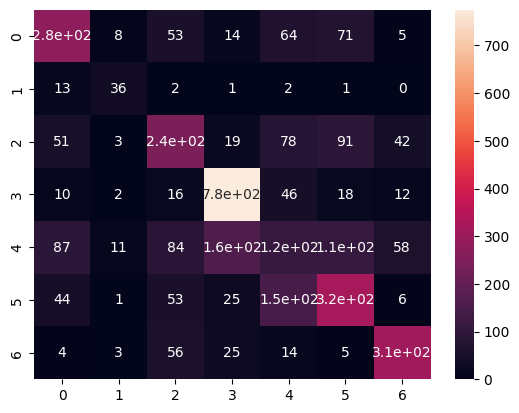

In [ ]:
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       491
           1       0.56      0.65      0.61        55
           2       0.48      0.46      0.47       528
           3       0.76      0.88      0.82       879
           4       0.25      0.18      0.21       626
           5       0.52      0.54      0.53       594
           6       0.72      0.74      0.73       416

    accuracy                           0.58      3589
   macro avg       0.55      0.57      0.56      3589
weighted avg       0.56      0.58      0.56      3589



## Classifying one single image

In [ ]:
image = cv2.imread('Computer_Vision_Masterclass_files/Images/person3.png')
#cv2.imshow(image)

In [ ]:
#To Display image
if image is not None:
    # Display the image
    cv2.imshow('image', image)

    # Wait for a key press and close the window
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error: Unable to read the image.")
 

In [ ]:
image.shape

(300, 400, 3)

In [ ]:
face_detector = cv2.CascadeClassifier('Computer_Vision_Masterclass_files/Cascades/haarcascade_frontalface_default.xml')

In [ ]:
original_image = image.copy()
faces = face_detector.detectMultiScale(original_image)

In [ ]:
faces

array([[162,  40, 128, 128]])

In [ ]:
roi = image[40:40 + 128, 162:162 + 128]
#cv2.imshow(roi)
#To Display image
if roi is not None:
    # Display the image
    cv2.imshow('roi', roi)

    # Wait for a key press and close the window
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error: Unable to read the image.")

In [ ]:
roi.shape

(128, 128, 3)

In [ ]:
roi = cv2.resize(roi, (48, 48))
#cv2_imshow(roi)
#To Display image
if roi is not None:
    # Display the image
    cv2.imshow('roi', roi)

    # Wait for a key press and close the window
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error: Unable to read the image.")

In [ ]:
roi.shape

(48, 48, 3)

In [ ]:
roi

array([[[ 28,  32,  37],
        [ 22,  28,  34],
        [ 33,  37,  42],
        ...,
        [ 12,  16,  17],
        [ 16,  21,  25],
        [ 16,  25,  30]],

       [[ 27,  31,  36],
        [ 31,  36,  41],
        [ 32,  36,  41],
        ...,
        [ 11,  16,  19],
        [ 13,  19,  24],
        [ 17,  25,  28]],

       [[ 27,  31,  36],
        [ 30,  34,  39],
        [ 26,  30,  35],
        ...,
        [ 12,  17,  20],
        [ 14,  20,  25],
        [ 20,  25,  27]],

       ...,

       [[162, 185, 197],
        [166, 188, 200],
        [166, 188, 200],
        ...,
        [162, 181, 188],
        [162, 182, 188],
        [161, 180, 187]],

       [[160, 184, 196],
        [165, 187, 199],
        [166, 188, 200],
        ...,
        [161, 180, 187],
        [162, 181, 187],
        [161, 180, 187]],

       [[160, 184, 196],
        [163, 187, 199],
        [165, 187, 199],
        ...,
        [160, 179, 186],
        [161, 180, 187],
        [162, 181, 188]]

In [ ]:
roi = roi / 255
roi

array([[[0.10980392, 0.1254902 , 0.14509804],
        [0.08627451, 0.10980392, 0.13333333],
        [0.12941176, 0.14509804, 0.16470588],
        ...,
        [0.04705882, 0.0627451 , 0.06666667],
        [0.0627451 , 0.08235294, 0.09803922],
        [0.0627451 , 0.09803922, 0.11764706]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.12156863, 0.14117647, 0.16078431],
        [0.1254902 , 0.14117647, 0.16078431],
        ...,
        [0.04313725, 0.0627451 , 0.0745098 ],
        [0.05098039, 0.0745098 , 0.09411765],
        [0.06666667, 0.09803922, 0.10980392]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.11764706, 0.13333333, 0.15294118],
        [0.10196078, 0.11764706, 0.1372549 ],
        ...,
        [0.04705882, 0.06666667, 0.07843137],
        [0.05490196, 0.07843137, 0.09803922],
        [0.07843137, 0.09803922, 0.10588235]],

       ...,

       [[0.63529412, 0.7254902 , 0.77254902],
        [0.65098039, 0.7372549 , 0.78431373],
        [0.65098039, 0

In [ ]:
roi.shape

(48, 48, 3)

In [ ]:
roi = np.expand_dims(roi, axis = 0)
roi.shape

(1, 48, 48, 3)

In [ ]:
probs = network_loaded.predict(roi)
probs

1/1 [==============================] - 0s 32ms/step


array([[5.28418983e-04, 1.14441411e-06, 1.24895188e-03, 8.93901825e-01,
        1.02064736e-01, 2.17870623e-03, 7.62211057e-05]], dtype=float32)

In [ ]:
result = np.argmax(probs)
result

3

In [ ]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

## Classifying multiple images

In [ ]:
image = cv2.imread('Computer_Vision_Masterclass_files/Images/faces_emotions.png')
#cv2_imshow(image)
#To Display image
if image is not None:
    # Display the image
    cv2.imshow('roi', image)

    # Wait for a key press and close the window
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error: Unable to read the image.")

In [ ]:
faces = face_detector.detectMultiScale(image)
faces

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [229, 242,  85,  85],
       [627, 241,  91,  91],
       [420,  43,  97,  97],
       [ 18, 243,  98,  98],
       [420, 242,  97,  97]])

In [ ]:
test_dataset.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [ ]:
for (x, y, w, h) in faces:
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi = image[y:y + h, x:x + w]
  #cv2_imshow(roi)
  roi = cv2.resize(roi, (48, 48))
  #cv2_imshow(roi)
  roi = roi / 255
  roi = np.expand_dims(roi, axis = 0)
  #print(roi.shape)
  prediction = network_loaded.predict(roi)
  #print(prediction)
  cv2.putText(image, emotions[np.argmax(prediction)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
#cv2_imshow(image)

if image is not None:
    # Display the image
    cv2.imshow('roi', image)

    # Wait for a key press and close the window
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error: Unable to read the image.")



1/1 [==============================] - 0s 33ms/step


## Classifying emotions in videos

In [ ]:
cap = cv2.VideoCapture('Computer_Vision_Masterclass_files/Videos/emotion_test01.mp4')
connected, video = cap.read()
print(connected, video.shape)

True (360, 640, 3)


In [ ]:
# fourcc.org
save_path = 'Computer_Vision_Masterclass_files/Videos/emotion_test01_result.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24
output_video = cv2.VideoWriter(save_path, fourcc, fps, (video.shape[1], video.shape[0]))

In [ ]:
while (cv2.waitKey(1) < 0):
  connected, frame = cap.read()
  if not connected:
    break
  faces = face_detector.detectMultiScale(frame, scaleFactor=1.2, minNeighbors=5, minSize=(30,30))
  if len(faces) > 0:
    for (x, y, w, h) in faces:
      frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
      roi = frame[y:y + h, x:x + w]
      roi = cv2.resize(roi, (48, 48))
      roi = roi / 255
      roi = np.expand_dims(roi, axis = 0)
      prediction = network_loaded.predict(roi)

      if prediction is not None:
        result = np.argmax(prediction)
        cv2.putText(frame, emotions[result], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

  #cv2_imshow(frame)
  output_video.write(frame)

print('End')
output_video.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 27ms/step
End
